## Load Modules/Libraries

In [31]:
import os
import sys

In [2]:
sys.path.insert(0, '/Users/joshua/Developer/civetqc')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from scipy.stats.distributions import loguniform

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score

In [5]:
from civetqc.data import CivetData
from civetqc.model import Model

## Define Paths and Helper Dataset Class

In [6]:
TRAINING_DATASET_PATH = "/Users/joshua/Developer/civetqc/data/processed/training_dataset.csv"
TESTING_DATASET_PATH = "/Users/joshua/Developer/civetqc/data/processed/testing_dataset.csv"

In [30]:
FIGURES_DIR = '/Users/joshua/Developer/civetqc/figures'

In [7]:
class SavedDataset:
    
    idvar = 'ID'
    qcvar = 'QC'
    feature_names = CivetData.feature_names
    
    def __init__(self, filepath: str):
        
        self.df = pd.read_csv(filepath)
        self.features = self.df[self.feature_names].to_numpy()
        self.target = self.df[self.qcvar]

## Training

In [8]:
training_data = SavedDataset(TRAINING_DATASET_PATH)

In [9]:
np.random.seed(0)

In [10]:
clf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5)

In [11]:
param_distributions = {
    'n_estimators': np.arange(50, 501),
    'max_depth': np.arange(5, 51),
    'max_features': loguniform(0.01, 1.0),
    'min_samples_split': np.arange(2, 6),
    'min_samples_leaf': np.arange(1, 6),
}

In [12]:
search = RandomizedSearchCV(clf, param_distributions, cv=cv, scoring='roc_auc', n_iter=50)

In [13]:
search.fit(training_data.features, training_data.target)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                                        'max_features': <scipy.stats._distn_infrastructur...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499, 500])},
                   scoring='roc_auc')

In [14]:
round(search.best_score_, 2)

0.91

In [15]:
best_estimator = search.best_estimator_

## Plot Discrimination Thresholds for Best Estimator

In [16]:
discrimination_thresholds = np.arange(0, 1.1, .1)

In [17]:
scores = {
    'Precision': [],
    'Recall': [],
    'F2': []
}

In [18]:
for threshold in discrimination_thresholds:
    probabilities = best_estimator.predict_proba(training_data.features)[:, 1]
    predictions = np.where(probabilities > threshold, 1, 0)
    scores['Precision'].append(precision_score(training_data.target, predictions, zero_division=1))
    scores['Recall'].append(recall_score(training_data.target, predictions))
    scores['F2'].append(fbeta_score(training_data.target, predictions, beta=2))

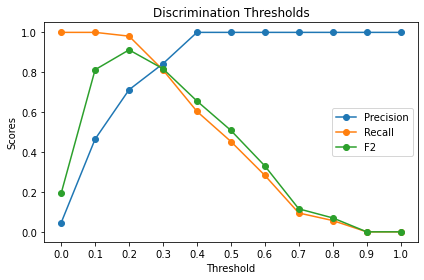

In [32]:
fig, ax = plt.subplots()
for key, value in scores.items():
    ax.plot(discrimination_thresholds, scores[key], label=key, marker='o')
ax.set_xticks(discrimination_thresholds)
ax.set_xlabel("Threshold")
ax.set_ylabel("Scores")
ax.set_title("Discrimination Thresholds")
ax.legend()
fig.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'discrimination_thresholds.jpeg'), dpi=300)

In [21]:
model = Model(best_estimator, default_threshold=0.2)

In [22]:
print(classification_report(training_data.target, model.predict(training_data.features)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1163
           1       0.71      0.98      0.83        53

    accuracy                           0.98      1216
   macro avg       0.86      0.98      0.91      1216
weighted avg       0.99      0.98      0.98      1216



## Save Model

In [23]:
model.save()

## Testing

In [24]:
testing_data = SavedDataset(TESTING_DATASET_PATH)

In [25]:
predicted = model.predict(testing_data.features)

In [26]:
print(classification_report(testing_data.target, predicted))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        98
           1       0.88      1.00      0.94        22

    accuracy                           0.97       120
   macro avg       0.94      0.98      0.96       120
weighted avg       0.98      0.97      0.98       120



In [27]:
round(roc_auc_score(testing_data.target, predicted), 2)

0.98